In [1]:
%load_ext autoreload
%autoreload 2

# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь встраивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

In [2]:
# !pip install tensorflow==1.14

In [3]:
# !git clone https://github.com/charlesq34/frustum-pointnets.git

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [4]:
import ssd

/Users/niksaz/anaconda3/envs/sdc2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/niksaz/anaconda3/envs/sdc2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/niksaz/anaconda3/envs/sdc2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/niksaz/anaconda3/envs/sdc2/lib/python3.5/s

In [5]:
ssd_detector = ssd.SSD('tmp')

### 3D object detection

Чтобы воспользоваться предобученной сетью, позаимствуйте код из https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [6]:
import os
import sys

root_dir = os.path.abspath('.')
frustum_pointnets_dir = os.path.join(root_dir, 'frustum-pointnets')
sys.path.append(os.path.join(frustum_pointnets_dir, 'kitti'))
sys.path.append(os.path.join(frustum_pointnets_dir, 'models'))
sys.path.append(os.path.join(frustum_pointnets_dir, 'train'))

In [7]:
NUM_POINTS = 1024
NUM_CHANNELS = 4
NUM_FRUSTUM_CLASSES = 2
SSD_THRESHOLD = 0.5
IOU_THRESHOLD = 0.7

In [8]:
import frustum_pointnets_test

class FrustumPointnet:
  def __init__(self, batch_size, num_points, model, model_path):
    self.sess, self.ops = frustum_pointnets_test.get_session_and_ops(batch_size, num_points, model, model_path)
    self.batch_size = batch_size
    
  def predict(self, point_cloud, one_hot_vec):
    return frustum_pointnets_test.inference(
      self.sess, self.ops, point_cloud, one_hot_vec, self.batch_size, NUM_FRUSTUM_CLASSES)

In [9]:
import frustum_pointnets_v1

frustum_checkpoint_path = 'frustum_pointnets_snapshots/log_v1/model.ckpt'
frustum_pointnet = FrustumPointnet(1, NUM_POINTS, frustum_pointnets_v1, frustum_checkpoint_path)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators suc

### Full pipeline

In [10]:
import provider
import kitti_object
from collections import namedtuple

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

class PipelineDetector(object):
  def __init__(self, frustum_pointnet, ssd_detector, ssd_threshold):
    self.frustum_pointnet = frustum_pointnet
    self.ssd_detector = ssd_detector
    self.ssd_threshold = ssd_threshold
    
  def predict(self, lidar, image, calibration):
    np.random.seed(94)
    # Create the scene right away and populate it with detections later.
    scene = Scene([])
    # Run 2D detector on the image.
    detector_2d_predictions = self.ssd_detector.predict(image)
    # Extract bounding boxes with vehicle classes and filter them by ssd_threshold.
    num_predictions = detector_2d_predictions['num_detections']
    detection_boxes = detector_2d_predictions['detection_boxes'][:num_predictions]
    detection_scores = detector_2d_predictions['detection_scores'][:num_predictions]
    detection_classes = detector_2d_predictions['detection_classes'][:num_predictions]
    
    filtered_by_vehicle = detection_classes == ssd.CAR_CLASS
    filtered_by_ssd_threshold = detection_scores > self.ssd_threshold
    filtered = filtered_by_vehicle & filtered_by_ssd_threshold
    num_predictions = np.count_nonzero(filtered)
    detection_boxes = detection_boxes[filtered]
    detection_scores = detection_scores[filtered]
    detection_classes = detection_classes[filtered]
    if num_predictions == 0:
      return scene
    # Process lidar point cloud and construct frustum examples.
    h, w, _ = image.shape
    p3d = lidar[:, :3]
    _, _, fov_inds = kitti_object.get_lidar_in_image_fov(p3d, calibration, 0, 0, w, h, return_more=True)
    p2d = calibration.project_velo_to_image(p3d.copy())
    p2d[:, 0] /= w
    p2d[:, 1] /= h
    pcds = []
    frustum_angles = []
    detection_2d_scores = []
    one_hot_vecs = []
    for detection_box, detection_score, detection_class in zip(detection_boxes, detection_scores, detection_classes):
      # plt.figure(figsize=(10, 10))
      # plt.scatter(lidar[:, 0], lidar[:, 1], c='black',  s=0.1)
      # Preprocessing as in kitti.prepare_data.extract_frustum_data.
      ymin, xmin, ymax, xmax = detection_box
      lidar_in_box = (xmin <= p2d[:, 0]) & (p2d[:, 0] <= xmax) & (ymin <= p2d[:, 1]) & (p2d[:, 1] <= ymax)
      filtered_lidar = lidar[lidar_in_box & fov_inds]
      if len(filtered_lidar) == 0:
        continue
      # plt.scatter(filtered_lidar[:, 0], filtered_lidar[:, 1], c='red',  s=0.1)

      box2d_center = np.array([(xmin + xmax) / 2.0 * w, (ymin + ymax) / 2.0 * h])
      uvdepth = np.zeros((1, 3))
      uvdepth[0, 0:2] = box2d_center
      uvdepth[0, 2] = 20  # some random depth
      box2d_center_rect = calibration.project_image_to_rect(uvdepth)
      frustum_angle = -1 * np.arctan2(box2d_center_rect[0, 2], box2d_center_rect[0, 0])
      # Shift by pi/2 as in provider.get_center_view_rot_angle.
      frustum_angle += np.pi / 2
      frustum_angles.append(frustum_angle)
      
      choice = np.random.choice(len(filtered_lidar), NUM_POINTS, replace=True)
      pcd = filtered_lidar[choice]
      pcd[:, :3] = calibration.project_velo_to_ref(pcd[:, :3]).copy()
      pcd[:, :3] = provider.rotate_pc_along_y(pcd[:, :3], frustum_angle).copy()
      pcds.append(np.copy(pcd))

      one_hot_vec = np.array((1.0, 0.0, 0.0))
      one_hot_vecs.append(one_hot_vec)
      
      detection_2d_scores.append(detection_score)

    # Run frustum inference (use batch to accelerate inference per frame).
    batch_output, batch_center_pred, \
    batch_hclass_pred, batch_hres_pred, \
    batch_sclass_pred, batch_sres_pred, batch_scores = \
      self.frustum_pointnet.predict(np.array(pcds), np.array(one_hot_vecs))
    # Populate detections for the scene.
    for i in range(len(batch_center_pred)):
      h, w, l, tx, ty, tz, ry = provider.from_prediction_to_label_format(
        batch_center_pred[i],
        batch_hclass_pred[i],
        batch_hres_pred[i],
        batch_sclass_pred[i],
        batch_sres_pred[i],
        frustum_angles[i])
      detection = Detection(
        xyz=np.array((tx, ty, tz)),
        angle=ry,
        lwh=np.array((l, w, h)),
        confidence=detection_2d_scores[i])
      scene.detections.append(detection)
    return scene

pipeline_detector = PipelineDetector(frustum_pointnet, ssd_detector, ssd_threshold=SSD_THRESHOLD)

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [11]:
import numpy as np
from matplotlib import pyplot as plt 

In [12]:
kitti_dataset_root = 'kitti_hw_dataset'
kitti_dataset = kitti_object.kitti_object(root_dir=kitti_dataset_root)
sample_id = 10
image = kitti_dataset.get_image(sample_id)
lidar = kitti_dataset.get_lidar(sample_id)
calibration = kitti_dataset.get_calibration(sample_id)
labels = kitti_dataset.get_label_objects(sample_id)

In [13]:
lidar

array([[ 6.3712e+01,  3.4000e-02,  2.3640e+00,  0.0000e+00],
       [ 4.2008e+01,  1.4500e-01,  1.6300e+00,  1.4000e-01],
       [ 4.2137e+01,  2.7800e-01,  1.6340e+00,  0.0000e+00],
       ...,
       [ 3.7450e+00, -1.4170e+00, -1.7510e+00,  4.1000e-01],
       [ 3.7440e+00, -1.4030e+00, -1.7480e+00,  3.5000e-01],
       [ 3.7520e+00, -1.3920e+00, -1.7500e+00,  0.0000e+00]],
      dtype=float32)

(-50, 50)

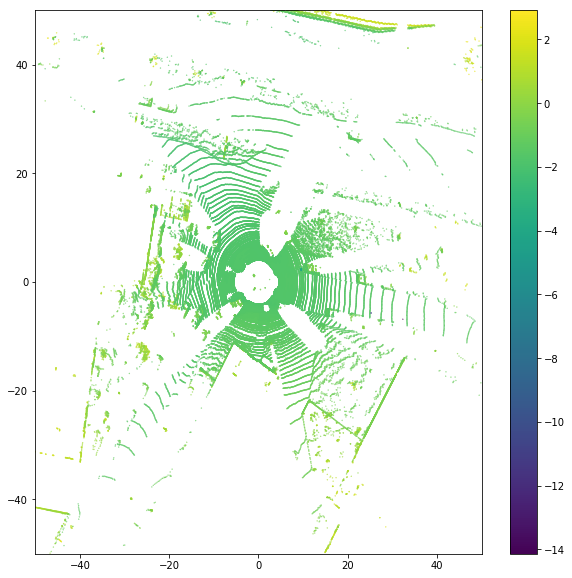

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(lidar[:, 0], lidar[:, 1], c=lidar[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

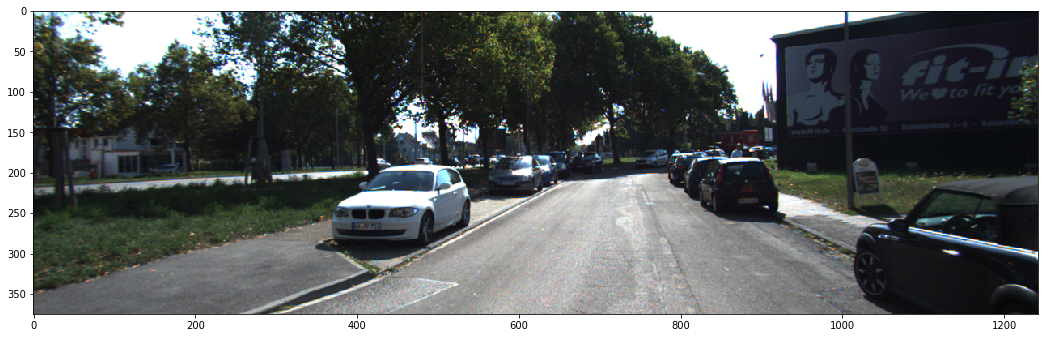

In [15]:
import cv2

plt.figure(figsize=(18, 18))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [16]:
calibration

In [17]:
labels

In [18]:
scene = pipeline_detector.predict(lidar, image, calibration)
scene

Scene(detections=[Detection(xyz=array([ 5.98343965,  1.80321753, 16.48081717]), angle=-1.4050291507065498, lwh=array([3.45288105, 1.55136601, 1.47538733]), confidence=1.0), Detection(xyz=array([-2.27977867,  1.76156346, 11.82496308]), angle=1.7432356734748446, lwh=array([3.95080495, 1.63697551, 1.46232112]), confidence=0.9999999), Detection(xyz=array([4.44056945, 1.83248735, 5.03215368]), angle=-1.4245756768162492, lwh=array([3.86406452, 1.6637376 , 1.56859828]), confidence=0.9999999), Detection(xyz=array([-0.16105288,  1.77892482, 23.87941354]), angle=1.7545834590586988, lwh=array([3.96680523, 1.61353554, 1.45398116]), confidence=0.99999976), Detection(xyz=array([11.69607931,  1.94597287, 52.38052237]), angle=2.2366095444278997, lwh=array([3.95743151, 1.64140571, 1.61717763]), confidence=0.9999994), Detection(xyz=array([ 4.72950879,  1.88483413, 42.77187119]), angle=2.0186115114526313, lwh=array([3.52265276, 1.53134067, 1.51906267]), confidence=0.9999949), Detection(xyz=array([ 6.9721

In [19]:
from shapely.geometry import Polygon
from shapely.affinity import rotate

VEHICLE_EQUIVALENT_CLASS = {'Car', 'Van', 'Truck'}

def create_polygon(x, y, w, l, angle):
  shifted_polygon = Polygon([[-w/2, -l/2], [-w/2, l/2], [w/2, l/2], [w/2, -l/2]])
  rotated_polygon = rotate(shifted_polygon, -angle, use_radians=True)
  xy = np.array(rotated_polygon.exterior.coords)
  xy[:, 0] += x
  xy[:, 1] += y
  return Polygon([xy[0], xy[1], xy[2], xy[3]])

def get_gt_boxes(labels, calibration):
  gt_boxes = []
  for label in labels:
    if label.type not in VEHICLE_EQUIVALENT_CLASS:
      continue
    x, y, _ = calibration.project_ref_to_velo(np.expand_dims(label.t, 0))[0]
    w, l = label.w, label.l
    angle = label.ry
    gt_boxes.append(create_polygon(x, y, w, l, angle))
  return gt_boxes
    
def get_dt_boxes(detections, calibration):
  dt_boxes = []
  for detection in detections:
    x, y, _ = calibration.project_ref_to_velo(np.expand_dims(detection.xyz, 0))[0]
    l, w, _ = detection.lwh
    angle = detection.angle
    dt_boxes.append(create_polygon(x, y, w, l, angle))
  return dt_boxes

In [20]:
gt_boxes = get_gt_boxes(labels, calibration)
gt_boxes

In [21]:
dt_boxes = get_dt_boxes(scene.detections, calibration)
dt_boxes

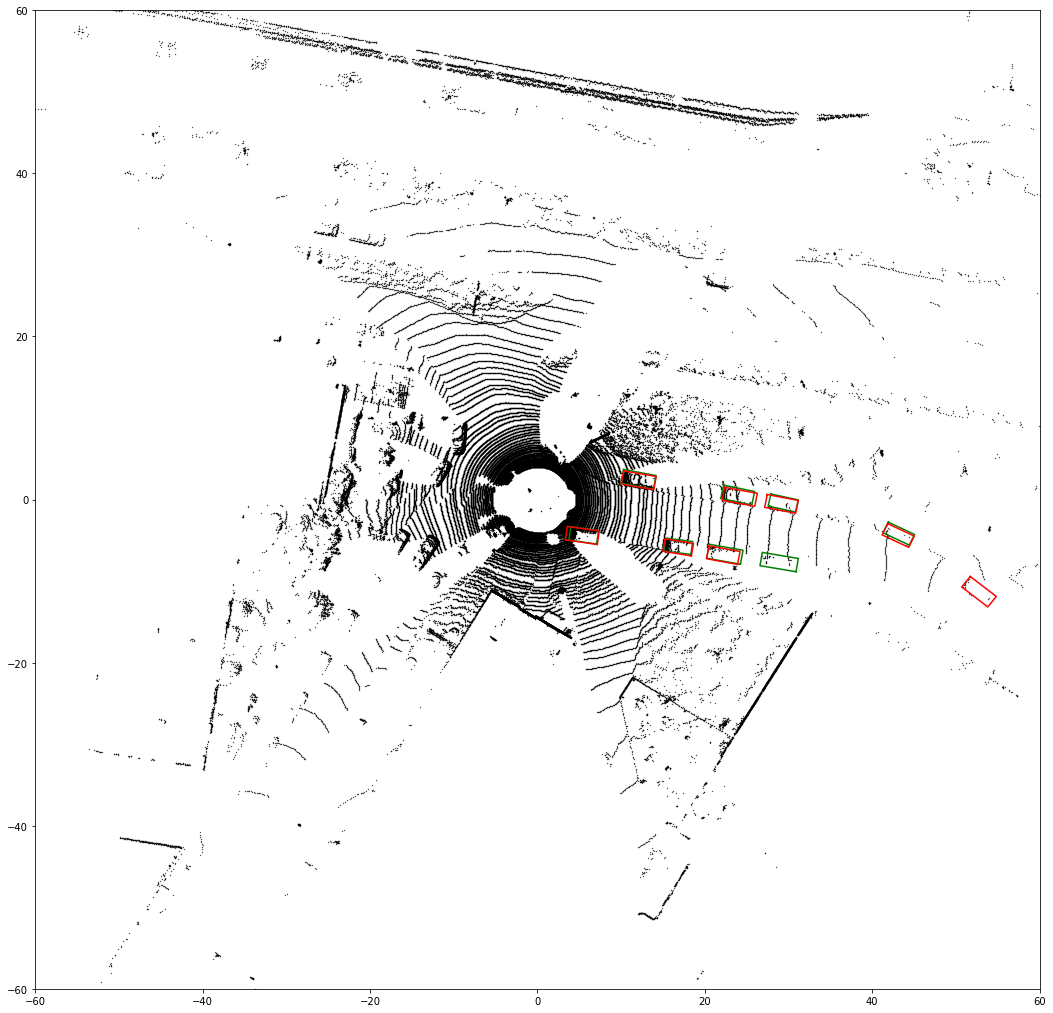

In [22]:
VEHICLE_EQUIVALENT_CLASS = {'Car', 'Van', 'Truck'}

fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(lidar[:, 0], lidar[:, 1], c='black',  s=0.1)
for gt_box in gt_boxes:
  xy = np.array(gt_box.exterior.coords)
  ax.plot(xy[:, 0], xy[:, 1], c='green')

for dt_box in dt_boxes:
  xy = np.array(dt_box.exterior.coords)
  ax.plot(xy[:, 0], xy[:, 1], c='red')

plt.xlim((-60, 60))
plt.ylim((-60, 60))
plt.show()

In [23]:
# Adapted from eval_det.

def voc_ap(rec, prec, use_07_metric=False):
  """ ap = voc_ap(rec, prec, [use_07_metric])
  Compute VOC AP given precision and recall.
  If use_07_metric is true, uses the
  VOC 07 11 point method (default:False).
  """
  if use_07_metric:
    # 11 point metric
    ap = 0.
    for t in np.arange(0., 1.1, 0.1):
      if np.sum(rec >= t) == 0:
        p = 0
      else:
        p = np.max(prec[rec >= t])
      ap = ap + p / 11.
  else:
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
      mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
  return ap

In [24]:
def get_iou(polygon1, polygon2):
  return polygon1.intersection(polygon2).area / polygon1.union(polygon2).area

In [25]:
# Adapted from eval_det.

def eval_det_cls(pred, gt, ovthresh=0.25, use_07_metric=False):
  # construct gt objects
  class_recs = {}  # {img_id: {'bbox': bbox list, 'det': matched list}}
  npos = 0
  for img_id in gt.keys():
    bbox = np.array(gt[img_id])
    det = [False] * len(bbox)
    npos += len(bbox)
    class_recs[img_id] = {'bbox': bbox, 'det': det}
  # pad empty list to all other imgids
  for img_id in pred.keys():
    if img_id not in gt:
      class_recs[img_id] = {'bbox': np.array([]), 'det': []}

  # construct dets
  image_ids = []
  confidence = []
  BB = []
  for img_id in pred.keys():
    for box, score in pred[img_id]:
      image_ids.append(img_id)
      confidence.append(score)
      BB.append(box)
  confidence = np.array(confidence)
  BB = np.array(BB)  # (nd,4 or 8,3)

  # sort by confidence
  sorted_ind = np.argsort(-confidence)
  sorted_scores = np.sort(-confidence)
  BB = BB[sorted_ind, ...]
  image_ids = [image_ids[x] for x in sorted_ind]

  # go down dets and mark TPs and FPs
  nd = len(image_ids)
  tp = np.zeros(nd)
  fp = np.zeros(nd)
  for d in range(nd):
    R = class_recs[image_ids[d]]
    bb = BB[d]
    ovmax = -np.inf
    BBGT = R['bbox']

    if BBGT.size > 0:
      # compute overlaps
      for j in range(BBGT.shape[0]):
        iou = get_iou(bb, BBGT[j])
        if iou > ovmax:
          ovmax = iou
          jmax = j

    if ovmax > ovthresh:
      if not R['det'][jmax]:
        tp[d] = 1.
        R['det'][jmax] = 1
      else:
        fp[d] = 1.
    else:
      fp[d] = 1.

  # compute precision recall
  fp = np.cumsum(fp)
  tp = np.cumsum(tp)
  rec = tp / float(npos)
  # avoid divide by zero in case the first detection matches a difficult
  # ground truth
  prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
  ap = voc_ap(rec, prec, use_07_metric)

  return rec, prec, ap

In [26]:
pred = {10: [(dt_box, detection.confidence) for dt_box, detection in zip(dt_boxes, scene.detections)]}
gt = {10: gt_boxes}
rec, prec, ap = eval_det_cls(pred, gt, ovthresh=IOU_THRESHOLD)
ap

0.828125

In [27]:
import glob

def get_sample_ids_from_dir(sample_dir, pattern):
  sample_paths = [sample for sample in glob.glob(os.path.join(sample_dir, pattern))]
  sample_names = [os.path.basename(sample_path) for sample_path in sample_paths]
  sample_ids = [sample_name.split('.')[0] for sample_name in sample_names]
  sample_ids.sort()
  return sample_ids

kitti_calib_dir = os.path.join(kitti_dataset_root, 'training', 'calib')
kitti_image_2_dir = os.path.join(kitti_dataset_root, 'training', 'image_2')
kitti_label_2_dir = os.path.join(kitti_dataset_root, 'training', 'label_2')
kitt_velodyne_dir = os.path.join(kitti_dataset_root, 'training', 'velodyne')

sample_ids = get_sample_ids_from_dir(kitti_calib_dir, '*.txt')
assert sample_ids == get_sample_ids_from_dir(kitti_image_2_dir, '*.png')
assert sample_ids == get_sample_ids_from_dir(kitti_label_2_dir, '*.txt')
assert sample_ids == get_sample_ids_from_dir(kitt_velodyne_dir, '*.bin')
total_length = len(sample_ids)
total_length

1000

In [28]:
from tqdm.notebook import tqdm

pred = {}
gt = {}

np.random.seed(94)
sample_ids_to_test = np.random.choice(total_length, 100, replace=False)

for sample_id in tqdm(sample_ids_to_test):
  image = kitti_dataset.get_image(sample_id)
  lidar = kitti_dataset.get_lidar(sample_id)
  calibration = kitti_dataset.get_calibration(sample_id)
  labels = kitti_dataset.get_label_objects(sample_id)

  scene = pipeline_detector.predict(lidar, image, calibration)
  
  dt_boxes = get_dt_boxes(scene.detections, calibration)
  gt_boxes = get_gt_boxes(labels, calibration)
  
  pred[sample_id] = [(dt_box, detection.confidence) for dt_box, detection in zip(dt_boxes, scene.detections)]
  gt[sample_id] = gt_boxes

/Users/niksaz/HSE/self-driving-cars/hw02/frustrum/frustum_pointnets_test.py:109: RuntimeWarning: invalid value encountered in true_divide
  mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask, 1)  # B,


In [29]:
rec, prec, ap = eval_det_cls(pred, gt, ovthresh=IOU_THRESHOLD)
ap

0.3455028612386791